### Useful References
https://forum.pyro.ai/t/how-to-define-a-likelihood-function-in-numpyro/2968

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [41]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import os
import seaborn as sns

from datetime import date, timedelta

import numpy as np
import jax.numpy as jnp
from jax import random, vmap

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
from numpyro.infer import init_to_feasible, init_to_value

import scipy.stats

import mechafil.data as mecha_data
import mechafil.sim as np_sim
import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil_jax.constants as C
import mechafil_jax.minting as minting

import cel_utils.disk_utils as du
import scenario_generator.utils as u
from tqdm.auto import tqdm

In [3]:
token = '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'

start_date = date(2023, 7, 1)
current_date = date.today() - timedelta(days=3)
forecast_length = 365*8
end_date = current_date + timedelta(days=forecast_length)

offline_data = data.get_simulation_data(token, start_date, current_date, end_date)

print(start_date, current_date, end_date)

2023-07-01 2023-07-03 2031-07-01


In [4]:
# get historical RBP, RR, FPR for last 180 days to setup simulation trajectories
t_hist_rbp, hist_rbp = u.get_historical_daily_onboarded_power(current_date-timedelta(days=180), current_date)
t_hist_rr, hist_rr = u.get_historical_renewal_rate(current_date-timedelta(days=180), current_date)
t_hist_fpr, hist_fpr = u.get_historical_filplus_rate(current_date-timedelta(days=180), current_date)

smoothed_last_historical_rbp = np.median(hist_rbp[-30:])
smoothed_last_historical_rr = np.median(hist_rr[-30:])
smoothed_last_historical_fpr = np.median(hist_fpr[-30:])

print(smoothed_last_historical_rbp, smoothed_last_historical_rr, smoothed_last_historical_fpr)

6.078338623046875 0.6556211653492354 0.8572694379750334


In [5]:
storage_dir='input_hmc'
save_dir = '/Users/kiran/Documents/baseline_project/'
os.makedirs(storage_dir, exist_ok=True)
os.makedirs(save_dir, exist_ok=True)

In [30]:
sector_duration = 360
lock_target = 0.3
y = np.exp(lock_target) * jnp.ones(forecast_length)
    
def model():
    rbp_sample = numpyro.sample("rbp_exponent", dist.Beta(1, 10))
    sigma = numpyro.sample("sigma", dist.HalfNormal(0.5))  # models the variance on the observed lock target

    rr_trajectory = jnp.ones(forecast_length) * smoothed_last_historical_rr
    fpr_trajectory = jnp.ones(forecast_length) * smoothed_last_historical_fpr
    rbp_trajectory = smoothed_last_historical_rbp*jnp.exp(jnp.arange(forecast_length) * rbp_sample)
    
    simulation_results = sim.run_sim(
        rbp_trajectory,
        rr_trajectory,
        fpr_trajectory,
        lock_target,

        start_date,
        current_date,
        forecast_length,
        sector_duration,
        offline_data
    )
    
    l = simulation_results['network_locked'][-forecast_length:]
    cs = simulation_results['circ_supply'][-forecast_length:]
    l_over_cs = jnp.nan_to_num(jnp.clip(l/cs, a_min = 0))
    numpyro.sample("L_over_CS_target", dist.LogNormal(l_over_cs, sigma), obs=y)

In [49]:
# @du.cache_data(directory=storage_dir)
def run_mcmc():
    rng_key = random.PRNGKey(0)
    rng_key, rng_key_ = random.split(rng_key)

    ref_params = {
        'rbp_exponent': np.log(2)/365,
        'sigma': 0.1
    }
    
    # Run NUTS.
    kernel = NUTS(model, init_strategy=init_to_value(values=ref_params))
    num_samples = 500
    mcmc = MCMC(kernel, num_warmup=500, num_samples=num_samples)
    mcmc.run(rng_key_)
    
    return {'mcmc': mcmc}

mcmc = run_mcmc()['mcmc']

sample: 100%|████████████████████████████████████████| 2000/2000 [10:16<00:00,  3.24it/s, 3 steps of size 6.46e-01. acc. prob=0.92]


In [50]:
mcmc.print_summary()


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
  rbp_exponent      0.00      0.00      0.00      0.00      0.00   1011.25      1.00
         sigma      0.07      0.00      0.07      0.06      0.07    500.11      1.00

Number of divergences: 0


In [51]:
samps = mcmc.get_samples()

In [52]:
t = [current_date + timedelta(days=i) for i in range(forecast_length)]

<IPython.core.display.Javascript object>


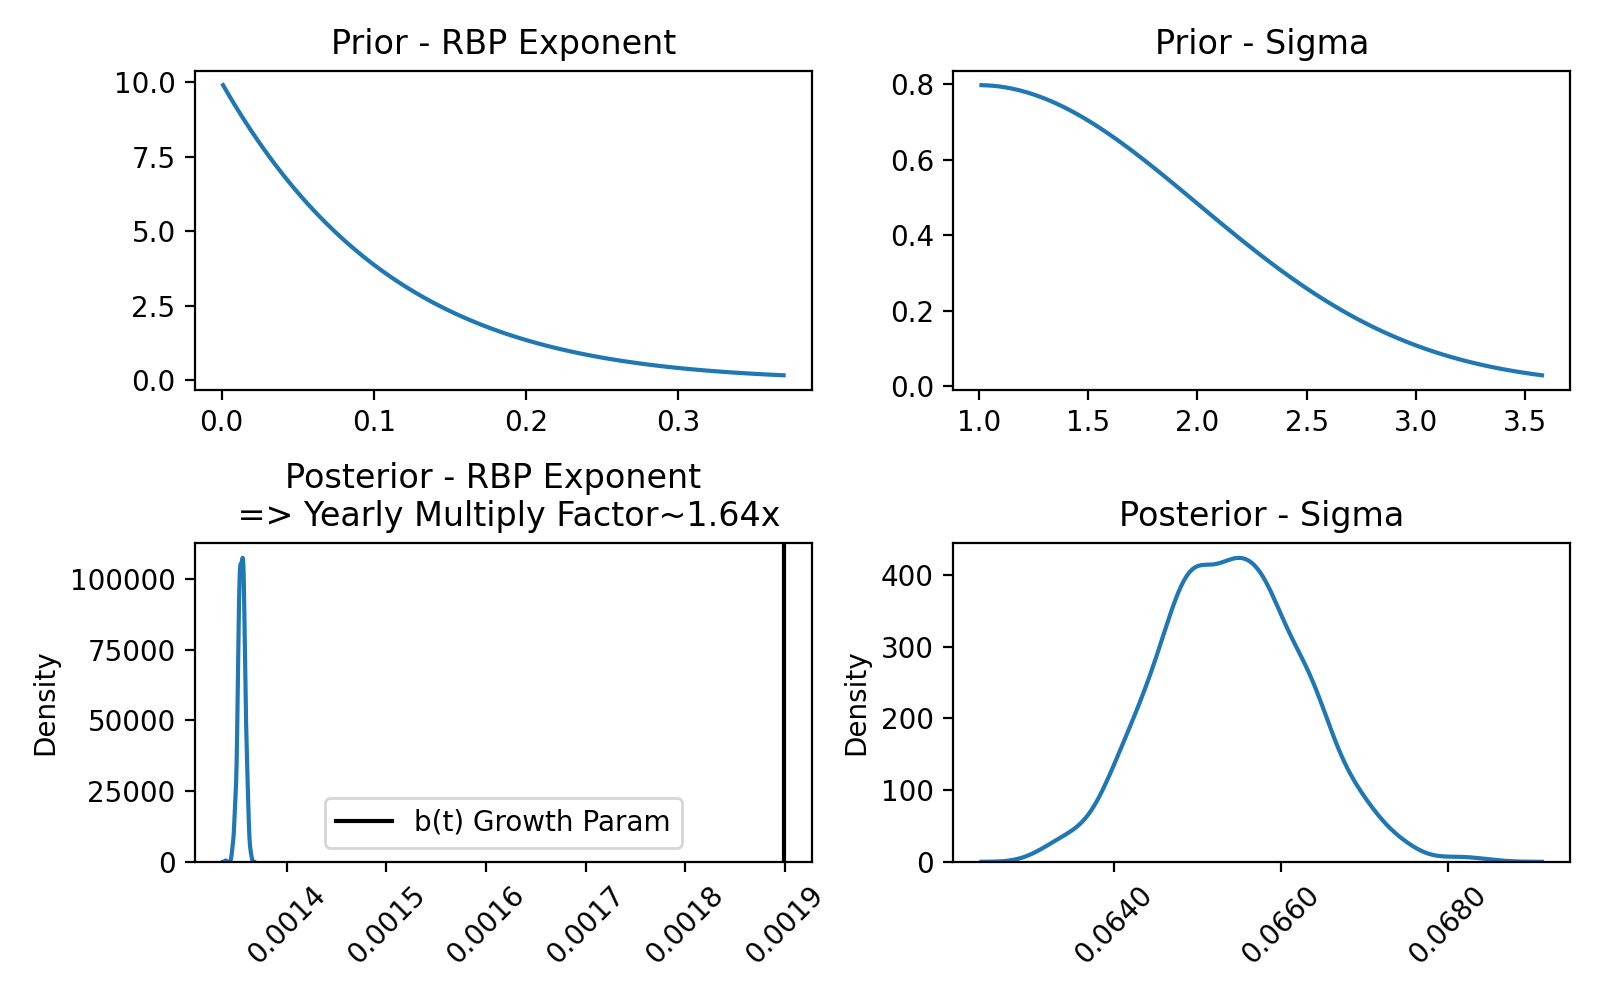

In [59]:
yearly_multiply_factor_approx = np.exp(np.mean(samps['rbp_exponent']) * 365)

plt.figure(figsize=(8,5))
plt.subplot(2,2,1)
a, b = 1, 10
x = np.linspace(scipy.stats.beta.ppf(0.01, a, b),
                scipy.stats.beta.ppf(0.99, a, b), 100)
plt.plot(x, scipy.stats.beta.pdf(x, a, b))
plt.title('Prior - RBP Exponent')

plt.subplot(2,2,2)
mu, std = 1, 1
x = np.linspace(scipy.stats.halfnorm.ppf(0.01, mu, std),
                scipy.stats.halfnorm.ppf(0.99, mu, std), 100)
plt.plot(x, scipy.stats.halfnorm.pdf(x, mu, std))
plt.title('Prior - Sigma')

plt.subplot(2,2,3)
sns.kdeplot(samps['rbp_exponent'])
plt.title('Posterior - RBP Exponent  \n => Yearly Multiply Factor~%0.02fx' % (yearly_multiply_factor_approx,))
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.4f}"))
plt.xticks(rotation=45)
plt.axvline(np.log(2)/365, color='k', label='b(t) Growth Param')
plt.legend()


plt.subplot(2,2,4)
sns.kdeplot(samps['sigma'])
plt.title('Posterior - Sigma')
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.4f}"))
plt.xticks(rotation=45)

plt.tight_layout()

plt.savefig(os.path.join(save_dir, 'dist.png'))

In [55]:
num_mc = 1000

keys_to_store = [
    'rb_total_power_eib',
    'qa_total_power_eib',
    'day_network_reward',
    'network_locked',
    'circ_supply',
    'l_over_cs'
]
# create arrays for each data to store
store_dict = {}
for k in keys_to_store:
    store_dict[k] = []
    
for i in tqdm(range(num_mc)):
    rbp_exponent = samps['rbp_exponent'][i]
    rbp_trajectory = smoothed_last_historical_rbp*jnp.exp(jnp.arange(forecast_length) * rbp_exponent)
    rr_trajectory = jnp.ones(forecast_length) * smoothed_last_historical_rr
    fpr_trajectory = jnp.ones(forecast_length) * smoothed_last_historical_fpr
    
    simulation_results = sim.run_sim(
        rbp_trajectory,
        rr_trajectory,
        fpr_trajectory,
        lock_target,

        start_date,
        current_date,
        forecast_length,
        sector_duration,
        offline_data
    )
    
    for k in keys_to_store:
        if k == 'l_over_cs':
            store_dict[k].append(simulation_results['network_locked'][-forecast_length:]/simulation_results['circ_supply'][-forecast_length:])
        else:
            store_dict[k].append(simulation_results[k][-forecast_length:])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [56]:
def compute_quantiles(key):
    x = np.asarray(store_dict[key])
    qvec = [0.05, 0.25, 0.50, 0.75, 0.95]
    qs = np.quantile(x, qvec, axis=0)
    return qs

<IPython.core.display.Javascript object>


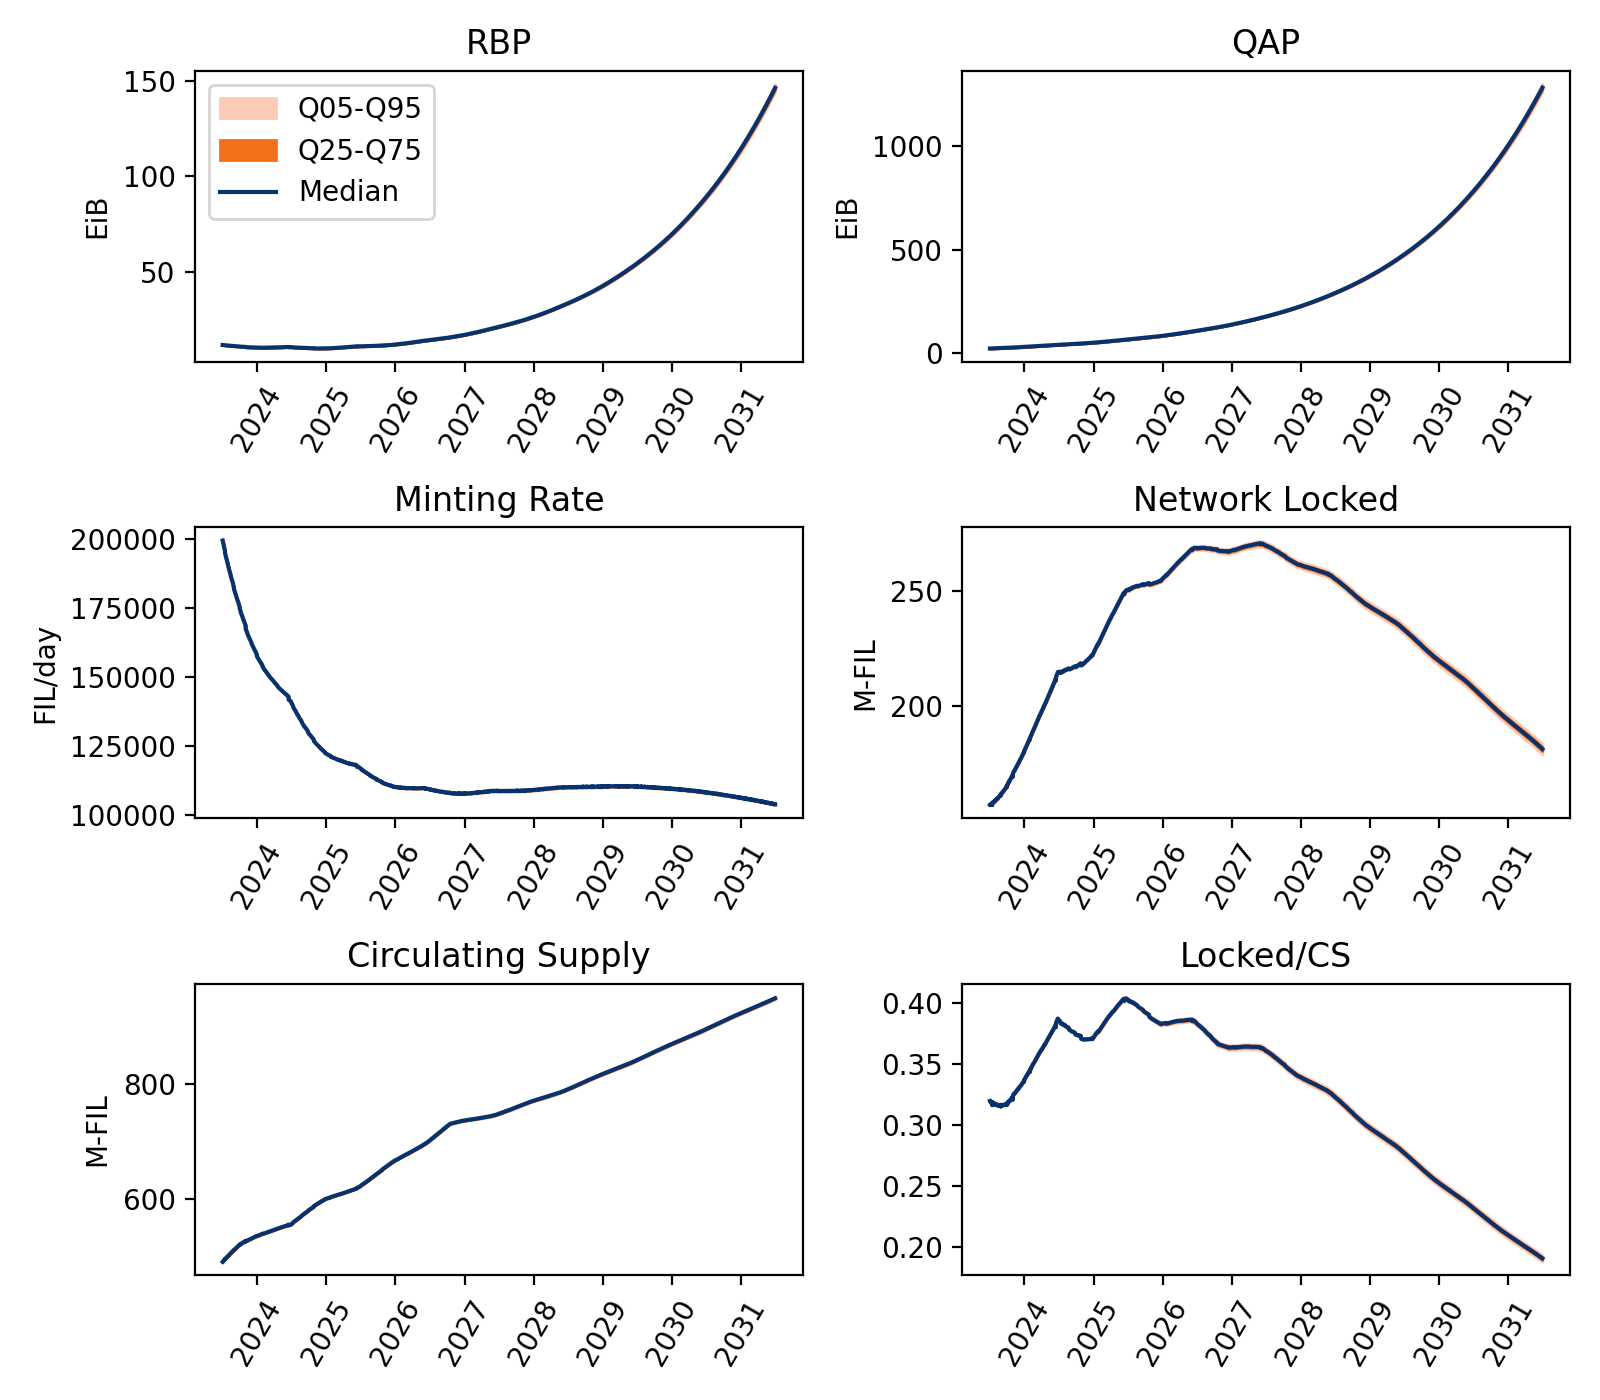

In [57]:
plt.figure(figsize=(8,7))

c_blue = mpl.colormaps['Blues']
c_orange = mpl.colormaps['Oranges']
c_red = mpl.colormaps['Reds']

k = 'rb_total_power_eib'
qs = compute_quantiles(k)
plt.subplot(3,2,1)
plt.fill_between(t, qs[0], qs[4], color=c_red(0.2), label='Q05-Q95')
plt.fill_between(t, qs[1], qs[3], color=c_orange(0.6), label='Q25-Q75')
plt.plot(t, qs[2], color=c_blue(0.99), label='Median')
plt.xticks(rotation=60)
plt.ylabel('EiB')
plt.title('RBP')
plt.legend()

k = 'qa_total_power_eib'
qs = compute_quantiles(k)
plt.subplot(3,2,2)
plt.fill_between(t, qs[0], qs[4], color=c_red(0.2), label='Q05-Q95')
plt.fill_between(t, qs[1], qs[3], color=c_orange(0.6), label='Q25-Q75')
plt.plot(t, qs[2], color=c_blue(0.99))
plt.xticks(rotation=60)
plt.ylabel('EiB')
plt.title('QAP')

k = 'day_network_reward'
qs = compute_quantiles(k)
plt.subplot(3,2,3)
plt.fill_between(t, qs[0], qs[4], color=c_red(0.2), label='Q05-Q95')
plt.fill_between(t, qs[1], qs[3], color=c_orange(0.6), label='Q25-Q75')
plt.plot(t, qs[2], color=c_blue(0.99))
plt.xticks(rotation=60)
plt.title('Minting Rate')
plt.ylabel('FIL/day')

k = 'network_locked'
qs = compute_quantiles(k)
plt.subplot(3,2,4)
plt.fill_between(t, qs[0]/1e6, qs[4]/1e6, color=c_red(0.2), label='Q05-Q95')
plt.fill_between(t, qs[1]/1e6, qs[3]/1e6, color=c_orange(0.6), label='Q25-Q75')
plt.plot(t, qs[2]/1e6, color=c_blue(0.99))
plt.xticks(rotation=60)
plt.title('Network Locked')
plt.ylabel('M-FIL')

k = 'circ_supply'
qs = compute_quantiles(k)
plt.subplot(3,2,5)
plt.fill_between(t, qs[0]/1e6, qs[4]/1e6, color=c_red(0.2), label='Q05-Q95')
plt.fill_between(t, qs[1]/1e6, qs[3]/1e6, color=c_orange(0.6), label='Q25-Q75')
plt.plot(t, qs[2]/1e6, color=c_blue(0.99))
plt.xticks(rotation=60)
plt.title('Circulating Supply')
plt.ylabel('M-FIL')

k = 'l_over_cs'
qs = compute_quantiles(k)
plt.subplot(3,2,6)
plt.fill_between(t, qs[0], qs[4], color=c_red(0.2), label='Q05-Q95')
plt.fill_between(t, qs[1], qs[3], color=c_orange(0.6), label='Q25-Q75')
plt.plot(t, qs[2], color=c_blue(0.99))
plt.xticks(rotation=60)
plt.title('Locked/CS')

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'hmc.png'))